<a href="https://colab.research.google.com/github/RKDash7/Modified-Chord/blob/main/Modified_Chord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

class ChordNode:
    def __init__(self, node_id):
        self.node_id = node_id
        self.successor = None
        self.keys = []

    def set_successor(self, successor):
        self.successor = successor

    def get_successor(self):
        return self.successor

class Chord:
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes
        self.nodes = self.create_nodes()
        self.assign_successors()

    def create_nodes(self):
        # Create nodes with unique IDs
        node_ids = random.sample(range(1, 2**10), self.num_nodes)
        return [ChordNode(node_id) for node_id in sorted(node_ids)]

    def assign_successors(self):
        # Assign successors in the Chord ring
        for i in range(self.num_nodes):
            self.nodes[i].set_successor(self.nodes[(i + 1) % self.num_nodes])

    def store_key(self, key):
        key_id = key % (2**4)  # Simple hash function
        responsible_node = self.get_responsible_node(key_id)
        responsible_node.keys.append(key_id)

    def get_responsible_node(self, key_id):
        # Find the responsible node for the key
        for node in self.nodes:
            if node.node_id >= key_id:
                return node
        return self.nodes[0]  # Wrap around if necessary

    def join(self, new_node_id):
        new_node = ChordNode(new_node_id)
        self.nodes.append(new_node)
        self.nodes.sort(key=lambda x: x.node_id)
        self.assign_successors()
        # Reassign keys to the new node
        for key in range(1024):  # Reassign existing keys (0 to 15)
            self.store_key(key)

    def leave(self, node_id):
        # Find the node to leave
        node_to_leave = next((node for node in self.nodes if node.node_id == node_id), None)
        if node_to_leave:
            successor = node_to_leave.get_successor()
            # Transfer keys to successor
            successor.keys.extend(node_to_leave.keys)
            self.nodes.remove(node_to_leave)
            self.assign_successors()  # Re-assign successors

    def plot(self,id):
        plt.figure(figsize=(7, 7))
        ax = plt.subplot(111, polar=True)

        # Plot nodes in a clockwise manner
        node_angles = [2 * np.pi * (node.node_id / (2 ** 10)) for node in self.nodes]
        ax.scatter(node_angles, [1] * len(self.nodes), label='Nodes', color='blue', s=100)

        # Plot keys
        for node in self.nodes:
            for key in node.keys:
                key_angle = 2 * np.pi * (key / (2 ** 10))
                ax.scatter(key_angle, [0.5], label='Keys', color='white', s=50)

        # Label the nodes
        for node in self.nodes:
            ax.text(2 * np.pi * (node.node_id / (2 ** 10)), 1.05, str(node.node_id),
                    horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

        # Remove degree markings
        ax.set_xticks([])  # Remove x-tick labels
        ax.set_yticks([])  # Remove y-tick labels

        # Set the direction of the plot to be clockwise
        ax.set_theta_direction(-1)

        # Display settings
        #plt.title('Chord Ring Visualization with Node Labels')
        #plt.legend(loc='upper left')
        plt.savefig(f'chord_{id}.svg', dpi=2000, bbox_inches='tight')
        plt.show()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Node:
    def __init__(self, node_id, m, layers, num_successors):
        self.node_id = node_id
        self.finger_tables = [[] for _ in range(layers)]  # Multilayered finger tables
        self.keys = {}
        self.cache = {}  # Cache for recently accessed keys
        self.successors = []  # Multiple successors
        self.num_successors = num_successors

    def store_key(self, key, value):
        self.keys[key] = value
        self.cache[key] = value  # Cache the stored key

    def get_key(self, key):
        if key in self.cache:
            return self.cache[key]  # Return from cache if available
        return self.keys.get(key, None)

class ModifiedChord:
    def __init__(self, m, layers, num_successors):
        self.m = m  # Number of bits for the ID space
        self.layers = layers
        self.nodes = []
        self.num_nodes = 0
        self.num_successors = num_successors

    def hash(self, key):
        return key % (2 ** self.m)

    def add_node(self):
        node_id = self.num_nodes
        new_node = Node(node_id, self.m, self.layers, self.num_successors)
        self.nodes.append(new_node)
        self.num_nodes += 1

        # Initialize finger tables and successors for the new node
        self.update_finger_tables()

    def update_finger_tables(self):
        for i in range(self.num_nodes):
            node = self.nodes[i]
            for layer in range(self.layers):
                #node.finger_tables[layer] = [(j + (2 ** layer)) % (2**self.m) for j in range(self.num_nodes)]
                node.finger_tables[layer] = [((i + (2 ** j) +layer) % (2 ** self.m))% (2 ** self.m) for j in range(self.m)]
            # Update successors
            if self.num_nodes > 1:
                start_index = (i + 1) % self.num_nodes
                node.successors = [self.nodes[(start_index + j) % self.num_nodes] for j in range(self.num_successors)]

    def store_key(self, key, value):
        node_index = self.hash(key) % self.num_nodes
        if self.num_nodes > 0:
            self.nodes[node_index].store_key(key, value)

    def get_key(self, key):
        node_index = self.hash(key) % self.num_nodes
        if self.num_nodes > 0:
            return self.nodes[node_index].get_key(key)
        return None

    def plot_network(self,node,path=None):
        print(node.successors)
        col=['blue','red']
        plt.figure(figsize=(7, 7))

        angle = np.linspace(0, 2 * np.pi, self.num_nodes, endpoint=False)
        y = np.cos(angle)
        x = np.sin(angle)

        for i in range(self.num_nodes):
            plt.text(x[i]+.1, y[i], str(self.nodes[i].node_id), fontsize=12, ha='center', va='center')

        for layer in range(self.layers):
                for j in range(self.m):
                    target_id = 4#(i + (2 ** j)) % self.num_nodes
                    d=self.nodes[4].finger_tables[layer][j]
                    if target_id < self.num_nodes:
                        plt.plot([x[target_id], x[d]], [y[target_id], y[d]], 'o-', alpha=0.5,color=col[layer])
                        #z=0
            # Draw connections based on finger tables
        #x[0]=1.5
       # y[0]=1.5
        #for layer in range(self.layers):
        #  for j in range(m):
       #     plt.plot([x[0], x[node.finger_tables[layer][j]]], [y[0], y[node.finger_tables[layer][j]]], 'bo-', alpha=0.5)
        if path is not None:
          for i in range(len(path) - 1):
            start_index = chord.nodes.index(chord.find_node(path[i]))
            end_index = chord.nodes.index(chord.find_node(path[i + 1]))
            plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=2)  # Solid red line for lookup path
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)

        plt.savefig('Fig.3.svg', dpi=2000, bbox_inches='tight')
        #plt.title("Modified Chord Network with Multiple Successors")
        #plt.gca().set_aspect('equal', adjustable='box')
        #plt.grid()
        plt.show()
    def print_finger_tables(self):
        for i, node in enumerate(self.nodes):
            print(f"Node {node.node_id}'s Finger Tables:{node.finger_tables}")
    def succ(self):
        print(self.nodes.successor)
    def hanging_line(self,point1, point2,control_point):

      t = np.linspace(0, 1, 100)
      curve = (1 - t)**2 * np.array(point1)[:, np.newaxis] + \
            2 * (1 - t) * t * np.array(control_point)[:, np.newaxis] + \
            t**2 * np.array(point2)[:, np.newaxis]
      return curve

      #return (x,y)
    def arrow(self,X,Y,x1,y1,x2,y2):
        style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        kw = dict(arrowstyle=style, color="k")
        a3 = patches.FancyArrowPatch((X[x1], Y[y1]), (X[x2], Y[y2]),
                             connectionstyle="arc3,rad=.5", **kw)
        return a3
    def lookup(self):

        plt.figure(figsize=(7, 7))

        angle = np.linspace(0, 2 * np.pi, self.num_nodes, endpoint=False)
        y = np.cos(angle)
        x = np.sin(angle)
        c=[0,0]#(x[30],y[0])
        for i in range(self.num_nodes):
            plt.text(x[i], y[i], str(self.nodes[i].node_id), fontsize=12, ha='center', va='center')

        style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        start_index =6#chord.nodes.index(6)
        end_index= 54#chord.nodes.index(54)
        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-0.5", **kw)


        plt.gca().add_patch(a3)
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #print(x[0])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path

        start_index = 54#chord.nodes.index(6)
        end_index= 62#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-0.5", **kw)


        plt.gca().add_patch(a3)
        #c=[-1,1.2]
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])

        #plt.gca().add_patch(a3)
        #plt.plot(x[0],x[0],x[1]-x[0],x[1]-x[0])
        print(x[1])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path
        start_index = 62#chord.nodes.index(6)
        end_index= 2#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=0.5", **kw)


        plt.gca().add_patch(a3)

        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #c=[0,1.2]
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #plt.arrow(0, 1.2, 0.1, 0.1, head_width=0.05, head_length=0.1, fc='red', ec='blue')
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path
        start_index = 2#chord.nodes.index(6)
        end_index= 4#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-0.5", **kw)


        plt.gca().add_patch(a3)
        #c=[0.4,1.2]
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        #plt.set_arrowstyle("Fancy,head_length=0.2")
        #plt.savefig('chord.svg',format='svg', dpi=1000, bbox_inches='tight')
        plt.savefig('Fig.6.svg', dpi=2000, bbox_inches='tight')
        #plt.title("Modified Chord Network with Multiple Successors")
        #plt.gca().set_aspect('equal', adjustable='box')
        #plt.grid()
        plt.show()
    def lookup1(self):

        plt.figure(figsize=(7, 7))

        angle = np.linspace(0, 2 * np.pi, self.num_nodes, endpoint=False)
        y = np.cos(angle)
        x = np.sin(angle)
        c=[0,0]#(x[30],y[0])
        for i in range(self.num_nodes):
            plt.text(x[i], y[i], str(self.nodes[i].node_id), fontsize=12, ha='center', va='center')

        style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        start_index =10#chord.nodes.index(6)
        end_index= 11#chord.nodes.index(54)
        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-2.5", **kw)


        plt.gca().add_patch(a3)
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #print(x[0])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path

        start_index = 10#chord.nodes.index(6)
        end_index= 12#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=1.5", **kw)


        plt.gca().add_patch(a3)
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        #plt.set_arrowstyle("Fancy,head_length=0.2")
        #plt.savefig('chord.svg',format='svg', dpi=1000, bbox_inches='tight')
        plt.savefig('Fig.2.svg', dpi=2000, bbox_inches='tight')
        #plt.title("Modified Chord Network with Multiple Successors")
        #plt.gca().set_aspect('equal', adjustable='box')
        #plt.grid()
        plt.show()
    def lookup2(self):

        plt.figure(figsize=(7, 7))

        angle = np.linspace(0, 2 * np.pi, self.num_nodes, endpoint=False)
        y = np.cos(angle)
        x = np.sin(angle)
        c=[0,0]#(x[30],y[0])
        for i in range(self.num_nodes):
            plt.text(x[i], y[i], str(self.nodes[i].node_id), fontsize=12, ha='center', va='center')

        style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        start_index =3#chord.nodes.index(6)
        end_index= 11#chord.nodes.index(54)
        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-.5", **kw)


        plt.gca().add_patch(a3)
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #print(x[0])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path

        start_index = 11#chord.nodes.index(6)
        end_index= 15#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=0.5", **kw)


        plt.gca().add_patch(a3)
        start_index = 15#chord.nodes.index(6)
        end_index= 1#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=0.5", **kw)

        start_index =3#chord.nodes.index(6)
        end_index= 11#chord.nodes.index(54)
        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-.5", **kw)


        plt.gca().add_patch(a3)

        start_index = 15#chord.nodes.index(6)
        end_index= 1#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),edgecolor='red',
                             connectionstyle="arc3,rad=-0.5", **kw)


        plt.gca().add_patch(a3)
        #point1=(x[start_index],y[start_index])
        #point2=(x[end_index],y[end_index])
        #x1 = self.hanging_line(point1, point2,c)
        #plt.plot(x[start_index], x[end_index])
        #plt.plot(y[start_index], y[end_index])
        #plt.plot(x1[0],x1[1])
        #print(x[0])
        #plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]], 'r-', linewidth=1)  # Solid red line for lookup path

        style = "Simple, tail_width=0.5, head_width=4, head_length=8"
        kw = dict(arrowstyle=style, color="r")
        start_index = 3#chord.nodes.index(6)
        end_index= 15#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=-0.5", **kw)


        plt.gca().add_patch(a3)
        start_index = 15#chord.nodes.index(6)
        end_index= 1#chord.nodes.index(54)

        a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),
                             connectionstyle="arc3,rad=0.5", **kw)
        plt.gca().add_patch(a3)
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        #plt.set_arrowstyle("Fancy,head_length=0.2")
        #plt.savefig('chord.svg',format='svg', dpi=1000, bbox_inches='tight')
        plt.savefig('Fig.1.svg', dpi=2000, bbox_inches='tight')
        #plt.title("Modified Chord Network with Multiple Successors")
        #plt.gca().set_aspect('equal', adjustable='box')
        #plt.grid()
        plt.show()


[<__main__.Node object at 0x79ecd0132610>, <__main__.Node object at 0x79ecd0133710>]


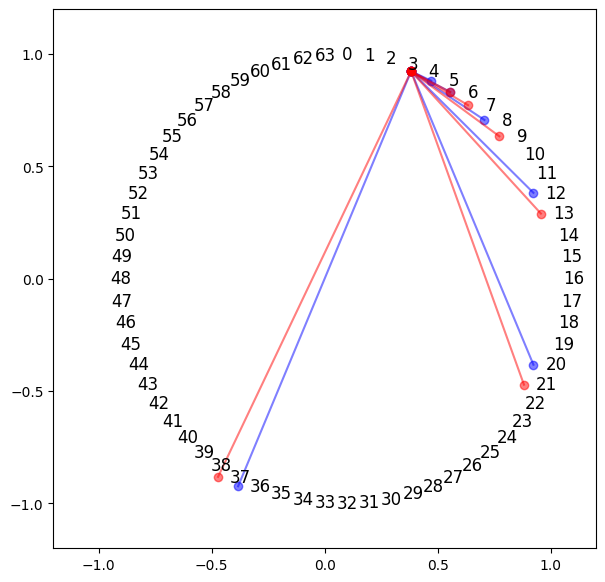

0.0980171403295606


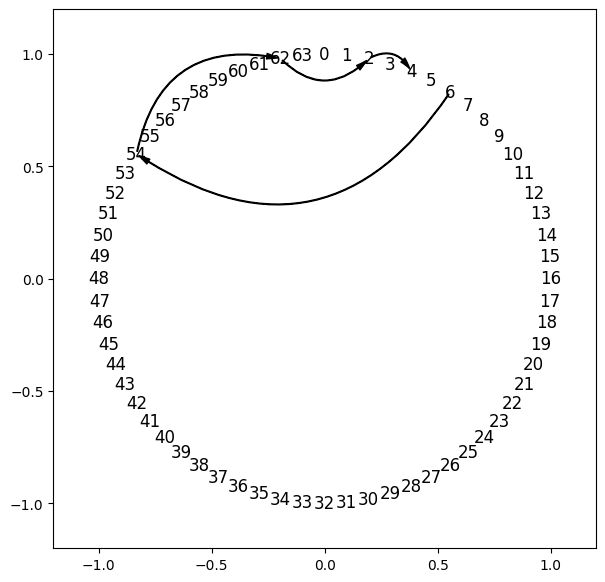

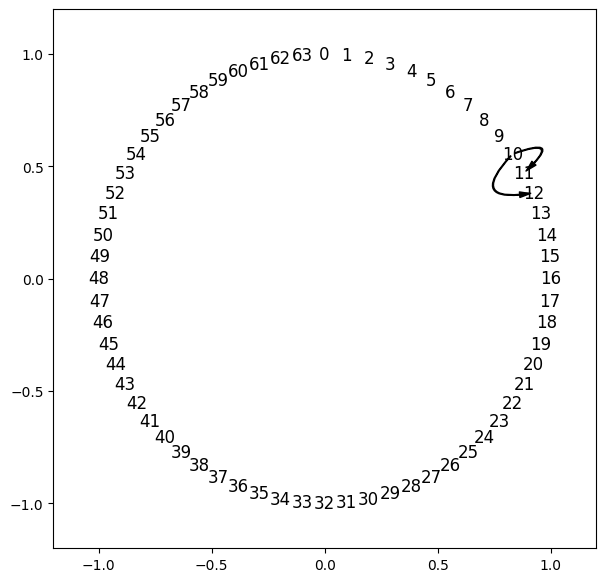

<ipython-input-4-a5705d05d118>:413: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a3 = patches.FancyArrowPatch((x[start_index], y[start_index]), (x[end_index], y[end_index]),edgecolor='red',


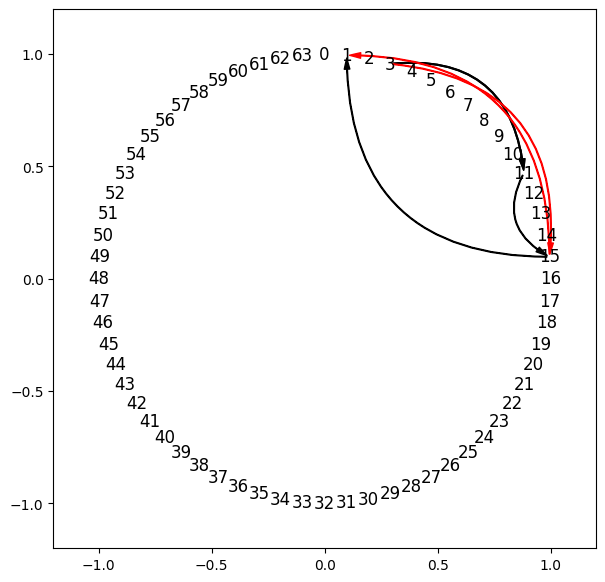

In [5]:
# Initialize and use the Modified Chord Protocol
m = 6  # Number of bits for the ID space (up to 8 nodes)
layers = 2  # Number of finger table layers
num_successors = 2  # Number of successors for each node

# Create an instance of the Modified Chord
chord = ModifiedChord(m, layers, num_successors)
num=64
# Add nodes to the Chord network
for _ in range(num):  # Adding 5 nodes
    chord.add_node()

# Store some keys in the Chord network
keys = np.arange(0,num)#[0, 1, 2, 3, 4]
values = np.arange(0,num)#["Value for 0", "Value for 1", "Value for 2", "Value for 3", "Value for 4"]
for key, value in zip(keys, values):
    chord.store_key(key, value)

# Retrieve values
#for key in keys:
#    print(f"Key {key}:", chord.get_key(key))
#path=[6,54]
# Plot the network
chord.plot_network(chord.nodes[10])
chord.lookup()
chord.lookup1()
chord.lookup2()
#chord.print_finger_tables()

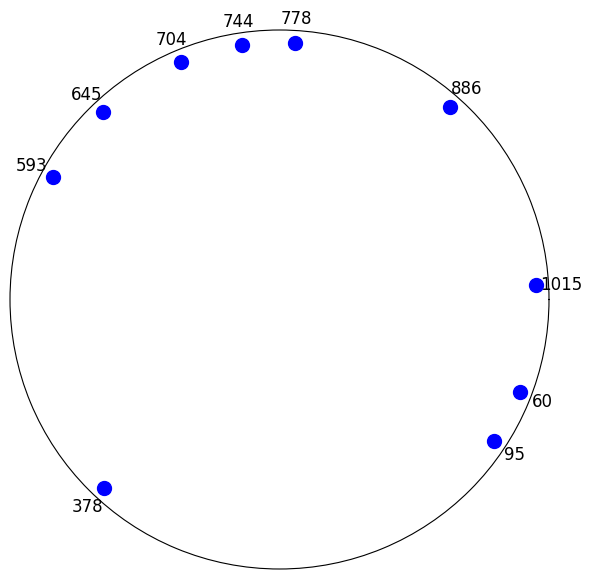

Joining new node with ID: 2


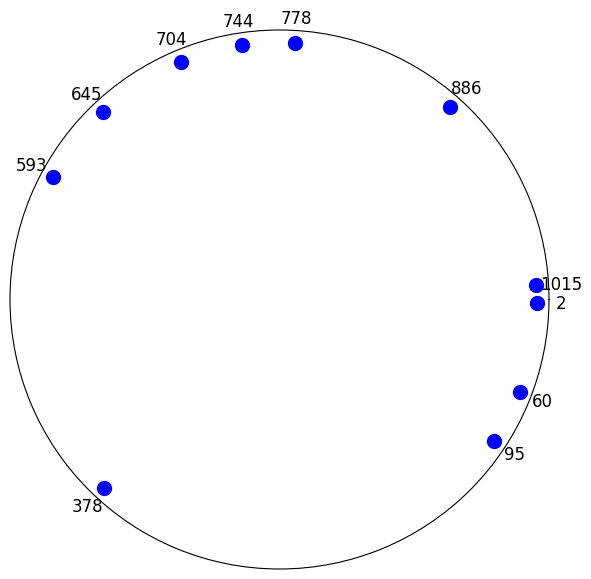

Node leaving with ID: 593


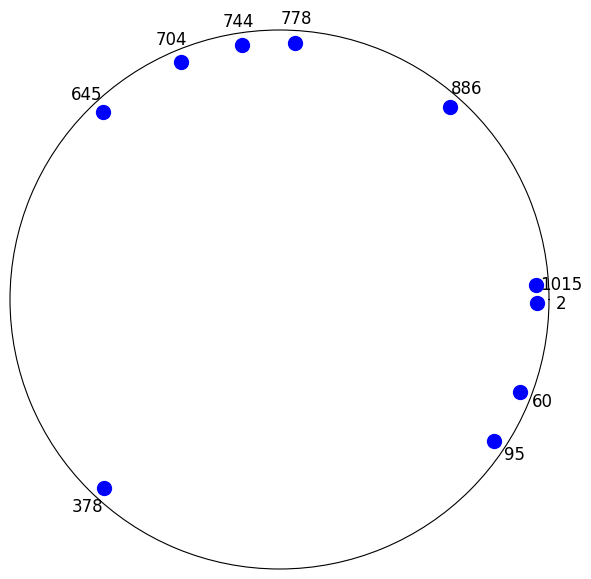

In [ ]:
if __name__ == "__main__":
    num_nodes = 10 # Initial number of nodes in the Chord ring
    chord = Chord(num_nodes)

    # Simulate storing keys in the Chord ring
    for key in range(1, 16):  # Store keys from 1 to 15
        chord.store_key(key)

    # Plot the initial Chord ring
    chord.plot(1)

    # Join a new node
    new_node_id = 2#random.randint(16, 30)  # Random ID for the new node
    print(f'Joining new node with ID: {new_node_id}')
    chord.join(new_node_id)

    # Plot the Chord ring after joining
    chord.plot(2)

    # Leave a node
    if chord.nodes:
        leaving_node_id = chord.nodes[4].node_id  # Example: Leave the first node
        print(f'Node leaving with ID: {leaving_node_id}')
        chord.leave(leaving_node_id)

        # Plot the Chord ring after a node leaves
        chord.plot(3)